In [61]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [62]:
df = pd.read_csv('/home/savin/Documents/DEV/dataset_fish/Датасет/db1/catch.csv')

In [63]:
df.head(3)

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own
0,4524386,2022-01-01,272,400,31.874,41,852296,7115834
1,474886,2022-01-01,277,886,0.476,1,5401178,1809581
2,3160994,2022-01-01,116,409,26.310,15,3869431,5258490


In [64]:
df.catch_volume.describe()

count    85087.000000
mean        18.463450
std         46.882700
min          0.001000
25%          0.284794
50%          1.781000
75%         11.050218
max        927.700000
Name: catch_volume, dtype: float64

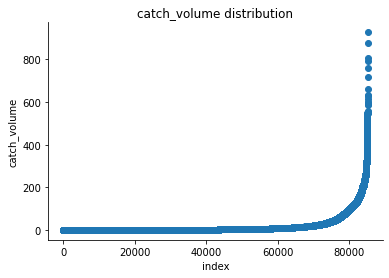

In [65]:
plt.scatter(range(df.shape[0]), np.sort(df['catch_volume'].values))
plt.xlabel('index')
plt.ylabel('catch_volume')
plt.title("catch_volume distribution")
sns.despine()

/home/savin/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


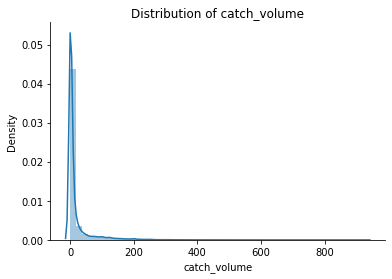

In [66]:
sns.distplot(df['catch_volume'])
plt.title("Distribution of catch_volume")
sns.despine()

In [67]:
print("Skewness: %f" % df['catch_volume'].skew())
print("Kurtosis: %f" % df['catch_volume'].kurt())

Skewness: 4.682572
Kurtosis: 31.197650


## Isolation Forest

### Anomaly Detection on Sales

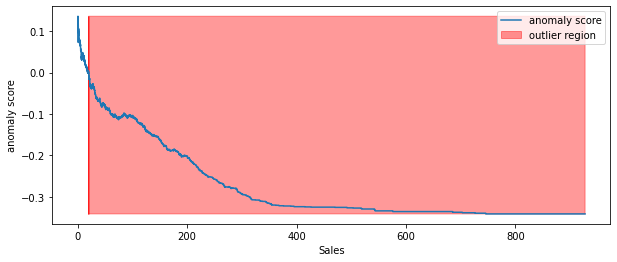

In [68]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['catch_volume'].values.reshape(-1, 1))
xx = np.linspace(df['catch_volume'].min(), df['catch_volume'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

In [69]:
df.loc[df['catch_volume'] > 20].head()

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own
0,4524386,2022-01-01,272,400,31.874,41,852296,7115834
2,3160994,2022-01-01,116,409,26.310,15,3869431,5258490
5,3327505,2022-01-01,274,292,31.074,1,3541627,1809581
13,8554643,2022-01-01,273,204,84.581,1,5421205,3846064
14,2498638,2022-01-01,270,400,120.000,12,2275054,9290322


### Anomaly detection on Profit

There were two regions that the data has low probability to appear: one on the left side of the distribution, another one on the right side of the distribution.

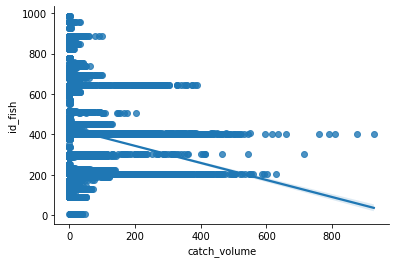

In [70]:
sns.regplot(x="catch_volume", y="id_fish", data=df)
sns.despine();

In [71]:
cols = ['catch_volume', 'id_fish']
df[cols].head()

,catch_volume,id_fish
0,31.874,400
1,0.476,886
2,26.310,409
3,9.541,292
4,0.062,113


In [72]:
minmax = MinMaxScaler(feature_range=(0, 1))
df[['catch_volume','id_fish']] = minmax.fit_transform(df[['catch_volume','id_fish']])
df[['catch_volume','id_fish']].head()

,catch_volume,id_fish
0,0.034357,0.402863
1,0.000512,0.899796
2,0.028359,0.412065
3,0.010284,0.292434
4,0.000066,0.109407


In [74]:
X1 = df['catch_volume'].values.reshape(-1,1)
X2 = df['id_fish'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

Cluster-based Local Outlier Factor (CBLOF)

OUTLIERS: 851 INLIERS: 84236


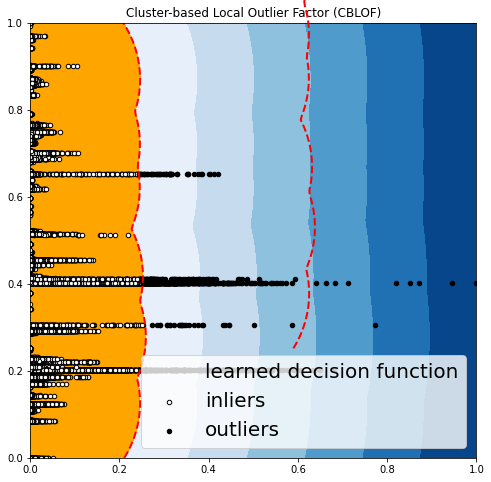

In [75]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['catch_volume'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['id_fish'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['catch_volume'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['id_fish'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold value to consider a datapoint inlier or outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

OUTLIERS: 781 INLIERS: 84306


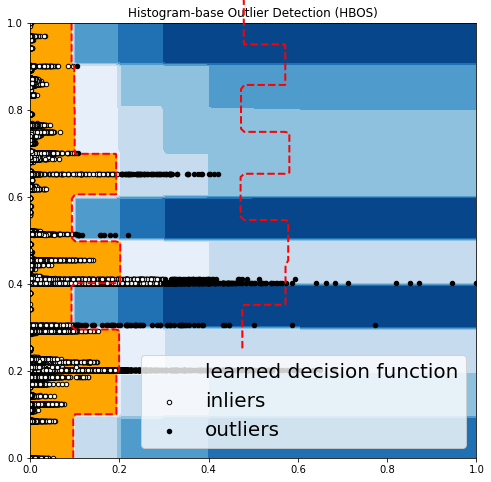

In [77]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['catch_volume'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['id_fish'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['catch_volume'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['id_fish'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

OUTLIERS:  825 INLIERS:  84262


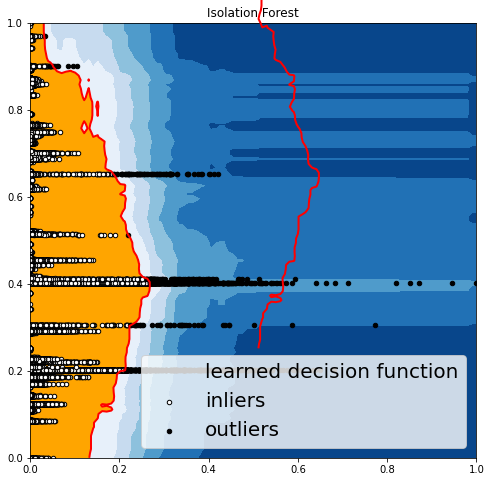

In [78]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['catch_volume'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['id_fish'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['catch_volume'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['id_fish'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

OUTLIERS:  689 INLIERS:  84398


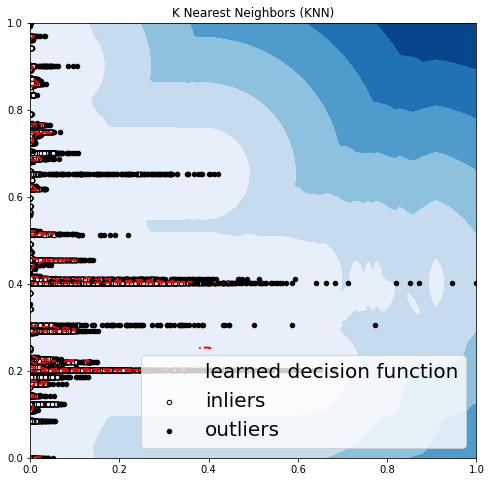

In [130]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['catch_volume'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['id_fish'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['catch_volume'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['id_fish'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K Nearest Neighbors (KNN)')
plt.show();

cursach

In [134]:
df1.head()

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own,outlier
0,4524386,2022-01-01,272,0.402863,0.034357,41,852296,7115834,0
1,474886,2022-01-01,277,0.899796,0.000512,1,5401178,1809581,0
2,3160994,2022-01-01,116,0.412065,0.028359,15,3869431,5258490,0
3,1234400,2022-01-01,272,0.292434,0.010284,1,2169057,1809581,0
4,1234400,2022-01-01,272,0.109407,0.000066,1,2169057,1809581,0


In [104]:
df1.loc[df1['outlier'] == 1].tail(10)

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own,outlier
84279,2562803,2022-04-20,274,0.202454,0.389747,1,6232048,7484551,1
84396,2323078,2022-04-20,267,0.208589,0.103929,1,7059636,7605979,1
84575,3714981,2022-04-20,116,0.412065,0.238867,15,2944056,2567272,1
84702,9233901,2022-04-20,267,0.208589,0.059463,1,4558681,2369769,1
84719,2679034,2022-04-20,116,0.412065,0.513741,15,3567010,78422,1
84772,8379477,2022-04-20,387,0.513292,0.158048,15,5857479,7478978,1
84779,8173742,2022-04-20,116,0.412065,0.485099,15,2297195,7656004,1
84797,3496590,2022-04-20,207,0.083845,0.041513,15,4683758,7372847,1
85000,6373850,2022-04-20,5435,0.417178,0.019316,97,9230594,1994512,1
85006,5843153,2022-04-20,502,0.170757,0.041607,1,9312800,6860313,1
